# Q1, 

Implement the ”Naive BlackJack” game in HW1 as a custom Gym environment. Follow the game rules
described in HW1. Test your environment by running random actions for 1000 episodes and report the
average reward




State Space:
S = {(P, O)|P = Player Total, O = Number of aces}
A = {Hit, Stand}
T: If action is Hit, a new card is added according to the deck. If the player goes
above 21, and the ace count is zero, the game is over and reward is given. If the
player goes above 21 with an ace, the ace count goes down by one and the total
goes down by 10. If the player stands,the game is over and a reward is given.
R: If the player busts, the reward = -1. The player then gets rewards + 1 for
P = 21, +0.878 for 20, +.746 for 19, +.606 for 18, +.458 for 17, and +.303 for
any number P < 17.


In [1]:
import importlib
import Blackjack_simulator as bjck
importlib.reload(bjck)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [ ]:
import Blackjack_simulator as bjck
from Blackjack_simulator import deal
from Blackjack_simulator import draw
import gymnasium as gym
from typing import Optional, Tuple, Union
from gymnasium import logger, spaces

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class BlackJackEnv(gym.Env):
    def __init__(self):
        super(BlackJackEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # Hit or Stand
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([21, 4]), dtype=np.float32)
        self.reset()

    def rewardfnc(self, score):
        return {21: 1.0, 20: 0.878, 19: 0.746, 18: 0.606, 17: 0.458}.get(score, 0.303)

    def step(self, action):
        if action == 0:  # Stand
            return np.array([self.score, self.aces], dtype=np.float32), self.rewardfnc(self.score), True, {}
        
        card = draw()
        self.score += card
        if card == 11:
            self.aces += 1

        if self.score > 21 and self.aces > 0:
            self.score -= 10
            self.aces -= 1

        done = self.score > 21
        reward = -1 if done else 0
        return np.array([self.score, self.aces], dtype=np.float32), reward, done, {}

    def reset(self):
        self.score, self.hand = deal()
        self.aces = sum(1 for card in self.hand if card == 11)
        return np.array([self.score, self.aces], dtype=np.float32)

env = BlackJackEnv()



In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Problem 2: Implementing DQN Variants (25 points)
In this problem, you will implement and compare three DQN variants:
1. Naive DQN (provided in the last code block in Lecture 6 Colab).
2. Double DQN.
3. Multi-step Return DQN.
# Tasks
1. Implement each algorithm and evalute them in the Naive BlackJack environment from Problem 1.
2. Perform hyperparameter tuning for each variant. Consider the following hyperparameters:
    • network structure (e.g. number of layers and number of neurons per layer)1
    .
    • batch size (e.g. 128, 256, 512)
    • Learning rate (e.g., 1e-3, 1e-4, 1e-5).
    • Discount factor (e.g., 0.9, 0.95, 0.99).
    • Number of steps for multi-step returns (e.g., 3, 5, 10).
    • Exploration strategy (e.g., ϵ decay rate).
    Performing hyper-parameter tuning by computing the total rewards across 10,000 episodes and
    choosing the hyper-parameter spec that maximize the total rewards.
3. Plot the reward vs. episode graph for each variants with the best found hyper-parameter setup

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 5000
LR = 1e-4
TAU = 0.005

# DQN Setup
n_actions = env.action_space.n
n_observations = 2
policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)
steps_done = 0

# Epsilon-Greedy Action Selection
def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)



In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    optimizer.step()

In [ ]:
num_episodes = 10000
total_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    episode_reward = 0

    for t in count():
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())

        reward = torch.tensor([reward], dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0) if not done else None
        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        
        episode_reward += reward.item()
        if done:
            total_rewards.append(episode_reward)
            break

    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {episode_reward}")


Episode 0, Total Reward: 0.4580000042915344
Episode 100, Total Reward: -1.0
Episode 200, Total Reward: 0.30300000309944153
Episode 300, Total Reward: -1.0
Episode 400, Total Reward: 0.30300000309944153
Episode 500, Total Reward: 0.6060000061988831
Episode 600, Total Reward: -1.0
Episode 700, Total Reward: 0.4580000042915344
Episode 800, Total Reward: 0.4580000042915344
Episode 900, Total Reward: 0.30300000309944153
Episode 1000, Total Reward: 1.0
Episode 1100, Total Reward: 0.6060000061988831
Episode 1200, Total Reward: 1.0
Episode 1300, Total Reward: 0.30300000309944153
Episode 1400, Total Reward: 0.4580000042915344
Episode 1500, Total Reward: 0.878000020980835
Episode 1600, Total Reward: 0.30300000309944153
Episode 1700, Total Reward: 0.4580000042915344
Episode 1800, Total Reward: 0.7459999918937683
Episode 1900, Total Reward: 0.4580000042915344
Episode 2000, Total Reward: 0.30300000309944153
Episode 2100, Total Reward: 1.0
Episode 2200, Total Reward: -1.0
Episode 2300, Total Reward:

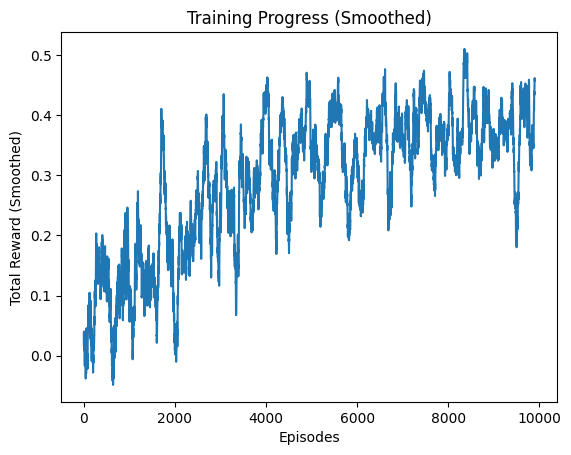

Average total reward for naive DQN: 0.45729000478982923


In [ ]:
def moving_average(data, window_size):
    """Compute the moving average of a list of numbers."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Define the window size for the moving average
window_size = 100

# Compute the moving average of the total rewards
smoothed_rewards = moving_average(total_rewards, window_size)

# Plot the smoothed rewards
plt.plot(smoothed_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward (Smoothed)')
plt.title('Training Progress (Smoothed)')
plt.show()

print(f'Average total reward for naive DQN: {np.mean(total_rewards[-100:])}')